In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from pathlib import Path

In [207]:
def get_subfolders(parent_dir):
    # returns only directories like group_00001, group_00002, etc
    return sorted([str(p) for p in Path(parent_dir).iterdir() if p.is_dir()])
    
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    print(f"Loading {len(files)} files from {fileformat}")
    for i, fname in enumerate(files):
        if i == 78960:
            break
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy_t/*.npy')
    ctens=consolidate(loaddir+'codelength_t/*.npy') 
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            't': ttens}

def takeaverage(data):
    nos=data['m'].sum(axis=0)
    weights=data['m']/data['m'].sum(axis=0,keepdims=True)
    eaverage=(data['e']*weights).sum(axis=0)
    caverage=(data['c']*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos}

In [208]:
# add in the dclm data
models = [9000, 18000, 27000, 36000, 47000]
data = {k:{} for k in models}

In [209]:
dclm_path = '/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4'
for model in models:
    if model == 47000:
        data_path = f"{dclm_path}/"
    else:
        data_path = f"{dclm_path}_{model}/"
    group_folders = get_subfolders(data_path)
    # print(group_folders)
    for i, group_path in enumerate(group_folders):
        new_data = loaddata(f"{group_path}/")

        if i == 0:
            # initialize dict storage
            data[model] = new_data
        else:
            # concatenate into existing arrays
            for key in data[model]:
                data[model][key] = np.concatenate(
                    (data[model][key], new_data[key]), axis=0
                )

Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00000/attn/*.npy
Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00000/entropy_t/*.npy
Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00000/codelength_t/*.npy
Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00000/tok/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00001/attn/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00001/entropy_t/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00001/codelength_t/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4_9000/group_00001/tok/*.npy


In [210]:
# average
avg_data = {}
for model in data:
    temp_data = {}
    print(f"Processing {model}")
    avg_data[model] = takeaverage(data[model])

Processing 9000
Processing 18000
Processing 27000
Processing 36000
Processing 47000


In [211]:
chars_per_token = 4.652658579289644

In [228]:
def get_codelength_stats(model_data):
    mask = model_data['m'][:, :-1]
    c_tensors = model_data['c']
    
    # n = number of valid sequences at each position
    n = mask.sum(axis=0)
    
    # Calculate weighted mean
    c_mean = (c_tensors * mask).sum(axis=0) / n
    
    # Calculate standard deviation (SD)
    c_var = (mask * (c_tensors - c_mean)**2).sum(axis=0) / n
    c_std = np.sqrt(c_var)
    
    # SEM = SD / sqrt(n)
    c_sem = c_std / np.sqrt(n)
    
    return c_mean, c_sem

In [213]:
for model in data:
    print(f'{model} samples: {avg_data[model]['n'][-1]}')

9000 samples: 79615
18000 samples: 89575
27000 samples: 79435
36000 samples: 80340
47000 samples: 78960


In [215]:
e = data[9000]['e']

In [218]:
e.shape, e[:78960].shape

((79615, 2047), (78960, 2047))

In [219]:
# slice off extra data so all checkpoints have same number of samples

In [221]:
clean_data = {}
for model, dicts in data.items():
    temp = {}
    for k, v in dicts.items():
        temp[k] = v[:78960]
    clean_data[model] = temp

In [223]:
# average
avg_data = {}
for model in clean_data:
    temp_data = {}
    print(f"Processing {model}")
    avg_data[model] = takeaverage(clean_data[model])
for model in clean_data:
    print(f'{model} samples: {avg_data[model]['n'][-1]}')

Processing 9000
Processing 18000
Processing 27000
Processing 36000
Processing 47000
9000 samples: 78960
18000 samples: 78960
27000 samples: 78960
36000 samples: 78960
47000 samples: 78960


In [230]:
codelength_data = {}
for i, model in enumerate(data):
    # Calculate stats from raw data
    c_mean, c_sem = get_codelength_stats(clean_data[model])
    codelength_data[model] = {'c_mean': c_mean, 'c_sem': c_sem}

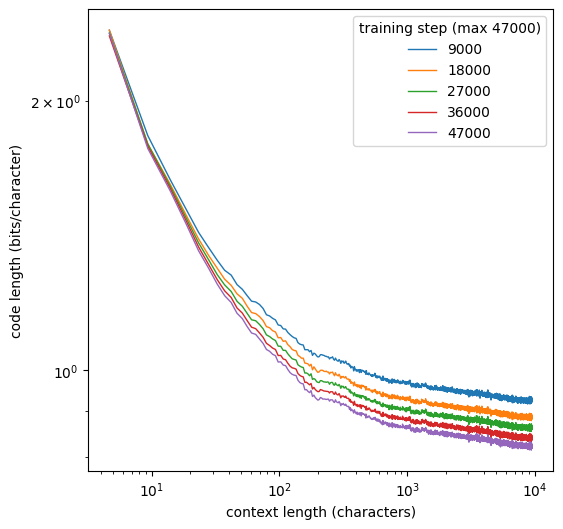

In [235]:
plt.figure(figsize=(6, 6))

for model in data:
    c_mean = codelength_data[model]['c_mean']
    c_sem = codelength_data[model]['c_sem']
        
    # Scale values by characters per token
    # need to multiply by 1 / char_per_tok --> divide by char_per_tok
    y_mean = c_mean / chars_per_token
    y_sem = c_sem / chars_per_token

    # X-axis (token positions)
    x_positions = (np.arange(len(y_mean)) + 1) * chars_per_token
    
    # Plot the mean line
    line, = plt.plot(x_positions, y_mean, lw=1, label=model)
    # print(model, model_names[model])

    # plt.fill_between(x_positions, y_mean - y_sem, y_mean + y_sem, color=line.get_color(), alpha=0.1)

    
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.ylabel('code length (bits/character)')
plt.xlabel('context length (characters)')
plt.legend(title='training step (max 47000)')

# # save as pdf
plt.savefig('c4_dclm_overtime.pdf', bbox_inches='tight')

In [237]:
# save data and codelength_data as pickle files
with open('c4_overtime_data.pkl', 'wb') as f:
    pickle.dump(clean_data, f)
with open('c4_overtime_codelength_data.pkl', 'wb') as f:
    pickle.dump(codelength_data, f)